In [7]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# data entry
car_data = "https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/refs/heads/main/data/car_data.csv"
car_data_frame = pd.read_csv(car_data)

#display(car_data_frame)


# Trabajo Práctico Semanal 1 2C25 - Regresión Polinómica
## Amalia Ochoa 107129

---

(a) Exploración de datos:
1. Cargar el archivo car_data.csv. Descartar las columnas correspondientes al nombre del auto y su
 dueño.
2.  Definir los conjuntos de entrenamiento, testeo y validación en base a la información en la columna Set. Una vez hecho este paso la información de esa feature no será de utilidad para la regresión.
 3. Indicar la proporción de las variables categóricas representando probabilidades. c: Si no sabe qué
 tipo de variable aleatoria es la categórica, deberá buscar dicha información.

In [8]:
# descarto las columnas corresppndientes al nombre del auto y su dueño
# valido que la columna exista y la elimino
if 'Car_Name' in car_data_frame.columns:
    car_data_frame = car_data_frame.drop(columns=['Car_Name'])

if 'Owner' in car_data_frame.columns:
    car_data_frame = car_data_frame.drop(columns=['Owner'])


# divido en base a la columna 'Set' (Train, Validation, Test)
train_df = car_data_frame[car_data_frame['Set'] == 'Train']
valid_df = car_data_frame[car_data_frame['Set'] == 'Validation']
test_df = car_data_frame[car_data_frame['Set'] == 'Test']

# ya agrupadas descarto la columna Set
train_df = train_df.drop(columns=['Set'])
valid_df = valid_df.drop(columns=['Set'])
test_df = test_df.drop(columns=['Set'])

# identifico variables categóricas para el conjunto de entrenamiento
categorical_columns = train_df.select_dtypes(include=['object']).columns
print("Variables categóricas:", list(categorical_columns), "\n")
# veo las proporciones de cada categoría en las variables categóricas
for col in categorical_columns:
    print(f"Proporciones de {col}:")
    print(train_df[col].value_counts(normalize=True))
    print("-" * 50)
    print("\n")

#sns.pairplot(train_df, hue='Fuel_Type')
#plt.show()

Variables categóricas: ['Fuel_Type', 'Seller_Type', 'Transmission'] 

Proporciones de Fuel_Type:
Fuel_Type
Petrol    0.796296
Diesel    0.196296
CNG       0.007407
Name: proportion, dtype: float64
--------------------------------------------------


Proporciones de Seller_Type:
Seller_Type
Dealer        0.633333
Individual    0.366667
Name: proportion, dtype: float64
--------------------------------------------------


Proporciones de Transmission:
Transmission
Manual       0.859259
Automatic    0.140741
Name: proportion, dtype: float64
--------------------------------------------------




 Hay determinados tipos de variables que precisan tomar valores numéricos para procesarse en un algoritmo, donde no es posible encontrar una relación de orden, donde las mismas simplemente representan categorías. Se suele codificar a las variables categóricas sin relación de orden específica con representaciones One-Hot. Cada columna categórica, de K clases posibles, se convierte en K variables binarias donde siempre una y solamente una de ellas toma el valor 1. Por ejemplo para la variable categórica Fuel_Type, se codidfica Petrol como (1,0,0), Diesel como (0,1,0) y GNC como (0,0,1)

(b) Pre-procesamiento:
1.  Utilizar el comando OneHotEncoder (sklearn) para codificar las variables categóricas de más de dos clases como one-hot y las categóricas de dos clases como binarias.
2. Utilice el comando PolynomialFeatures (sklearn) para crear un mapa polinómico de orden 3 sobre las variables numéricas (exceptuando el precio de venta que será la variable a predecir).
3. Combinar y posteriormente normalizar las salidas de las operaciones anteriores. Herramientas recomendadas son ColumnTransformer y StandardScaler (sklearn)

In [9]:
# uso OneHotEncoder para codificar las variables categóricas de más de dos clases o binarias

# columnas categóricas de más de dos clases
multi_class_columns = [col for col in categorical_columns if train_df[col].nunique() > 2]
# columnas categóricas binarias
binary_class_columns = [col for col in categorical_columns if train_df[col].nunique() == 2]
# columnas numericas
numeric_columns = train_df.select_dtypes(exclude=['object']).drop(columns=['Selling_Price']).columns

#display(binary_class_columns) #Seller type, transmission
#display(multi_class_columns) #tengo fuel type

# preprocesamiento de las variables categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), multi_class_columns),
        ('binary', OneHotEncoder(drop='if_binary'), binary_class_columns),
        ('poly_num', PolynomialFeatures(degree=3, include_bias=False), numeric_columns),
    ], remainder='passthrough')

#fit_transform(X, y=None, **params)[source], SIN selling price
#Fit all transformers, transform the data and concatenate results.
X_train = preprocessor.fit_transform(train_df.drop(columns=['Selling_Price']))
print(preprocessor.get_feature_names_out())

#transform(X, **params)[source], SIN selling price
#Transform X separately by each transformer, concatenate results.
X_valid = preprocessor.transform(valid_df.drop(columns=['Selling_Price']))
X_test = preprocessor.transform(test_df.drop(columns=['Selling_Price']))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

#display(X_train)
#display(X_valid)
#display(X_test)

# separo la variable dependiente 'Selling_Price'
y_train = train_df['Selling_Price']
y_valid = valid_df['Selling_Price']
y_test = test_df['Selling_Price']

# Ver las dimensiones de los datos transformados y escalados
print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_valid: {X_valid.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")

#tiene 24 parametros

['onehot__Fuel_Type_CNG' 'onehot__Fuel_Type_Diesel'
 'onehot__Fuel_Type_Petrol' 'binary__Seller_Type_Individual'
 'binary__Transmission_Manual' 'poly_num__Year' 'poly_num__Present_Price'
 'poly_num__Kms_Driven' 'poly_num__Year^2' 'poly_num__Year Present_Price'
 'poly_num__Year Kms_Driven' 'poly_num__Present_Price^2'
 'poly_num__Present_Price Kms_Driven' 'poly_num__Kms_Driven^2'
 'poly_num__Year^3' 'poly_num__Year^2 Present_Price'
 'poly_num__Year^2 Kms_Driven' 'poly_num__Year Present_Price^2'
 'poly_num__Year Present_Price Kms_Driven' 'poly_num__Year Kms_Driven^2'
 'poly_num__Present_Price^3' 'poly_num__Present_Price^2 Kms_Driven'
 'poly_num__Present_Price Kms_Driven^2' 'poly_num__Kms_Driven^3']
Dimensiones de X_train: (270, 24)
Dimensiones de X_valid: (10, 24)
Dimensiones de X_test: (21, 24)


(c) Regresión Lineal:
1. Utilizar Pipeline (sklearn) para combinar las operaciones anteriores con una regresión lineal. Se recomienda utilizar LinearRegression (sklearn).
2. ¿Cuántos parámetros tiene el modelo? Explicar por qué.
3. Utilizar display para hacer un diagrama del sistema definido.
4. Entrenar el sistema descripto anteriormente.
5. Reportar el error cuadrático medio de entrenamiento y validación.

In [10]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import set_config


# Pipeline final con regresión lineal y normalizado
pipeline = Pipeline([('preprocesador',preprocessor),('scaler',StandardScaler()),('regressor',LinearRegression())])

# Mostrar diagrama del pipeline
set_config(display='diagram')
display(pipeline)

# Entrenar el pipeline directamente
pipeline.fit(train_df.drop(columns=['Selling_Price']), train_df['Selling_Price'])

# Predicciones
y_train_pred = pipeline.predict(train_df.drop(columns=['Selling_Price']))
y_valid_pred = pipeline.predict(valid_df.drop(columns=['Selling_Price']))

# Errores
mse_train = mean_squared_error(train_df['Selling_Price'], y_train_pred)
mse_valid = mean_squared_error(valid_df['Selling_Price'], y_valid_pred)

print(f"MSE entrenamiento: {mse_train:.4f}")
print(f"MSE validación: {mse_valid:.4f}")

# Número de parámetros = coeficientes + intercepto
n_params = pipeline.named_steps['regressor'].coef_.shape[0] + 1
print(f"Cantidad de parámetros del modelo: {n_params}")


Pipeline(steps=[('preprocesador',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot', OneHotEncoder(),
                                                  ['Fuel_Type']),
                                                 ('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Seller_Type',
                                                   'Transmission']),
                                                 ('poly_num',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  Index(['Year', 'Present_Price', 'Kms_Driven'], dtype='object'))])),
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

MSE entrenamiento: 0.4727
MSE validación: 0.5420
Cantidad de parámetros del modelo: 25


(d) Regularización:
 1. Combinar Ridge (sklearn) con Pipeline para implementar una regresión polinómica regularizada.
 2. Entrenar una regresión regularizada para diferentes valores de $10^{−6} < λ < 10^{−2}$.
 3. Graficar el error cuadrático medio de entrenamiento y validación en función de λ.
 4. Reportar el λ que minimiza el error cuadrático medio de validación.
 5. Reportar el error cuadrático medio de testeo para el λ obtenido anteriormente

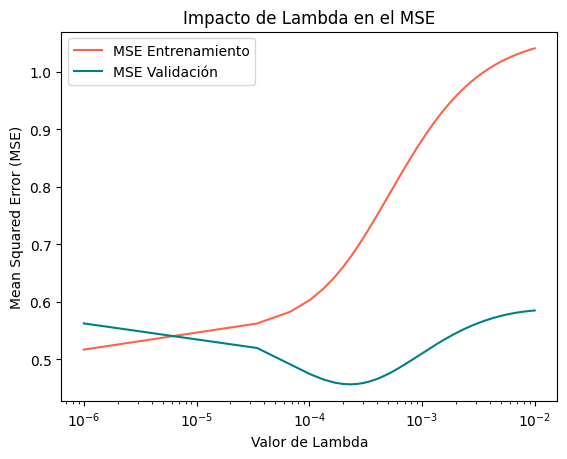

idx min de mse de val :  7
valor lambda que minimiza mse val:  0.00023509030100334448
El mse para lamda = 0.00023509030100334448 es 0.6979245310806217


In [16]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

from sklearn.linear_model import Ridge

# Definir valores de lambda (α en sklearn)
alpha_values = np.linspace(0.000001, 0.01, 300)  # desde 1e-6 hasta 1e2

# Listas para almacenar resultados
mse_train_list = []
mse_val_list = []
coefs_list = []

# separ la variable dependiente
X_train_raw = train_df.drop(columns=['Selling_Price'])
y_train = train_df['Selling_Price']

X_valid_raw = valid_df.drop(columns=['Selling_Price'])
y_valid = valid_df['Selling_Price']


# itero para alfa para hacer la regresión
for alpha_val in alpha_values:
    # no llamo al pipeline con el pipeline... hago otro que incluya ridge
    model_2 = Pipeline([('preprocessor',preprocessor),
              ('scaler',StandardScaler()),
              ('Ridge',Ridge(alpha = alpha_val))])

    # entreno el modelo
    model_2.fit(X_train_raw, y_train)

    # predigo con los sets de validacion
    y_train_pred = model_2.predict(X_train_raw)
    y_val_pred = model_2.predict(X_valid_raw)

    # MSE
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_val = mean_squared_error(y_valid, y_val_pred)

    # resultados
    mse_train_list.append(mse_train)
    mse_val_list.append(mse_val)

    # coeficientes del modelo Ridge
    coefs_list.append(model_2.named_steps['Ridge'].coef_)


# Grafico MSE en función de lambda (α)
plt.semilogx(alpha_values, mse_train_list, label="MSE Entrenamiento",color = 'Tomato')
plt.semilogx(alpha_values, mse_val_list, label="MSE Validación",color = 'Teal')
plt.xlabel("Valor de Lambda")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.title("Impacto de Lambda en el MSE")
plt.show()

#busco el argumento minimo del array de los valores de mse de validacion
idx_min_val = np.argmin(mse_val_list)
print("idx min de mse de val : ", idx_min_val)
lamda_min_val = alpha_values[idx_min_val]
print("valor lambda que minimiza mse val: ", lamda_min_val)

X_test_raw = test_df.drop(columns=['Selling_Price'])
y_test = test_df['Selling_Price']
model_3 = Pipeline([('preprocessor',preprocessor), ('Ridge',Ridge(alpha = lamda_min_val))])  #sin normalizar

model_3.fit(X_train_raw,y_train)
y_test_pred = model_3.predict(X_test_raw)
mse_test = mean_squared_error(y_test, y_test_pred)


print(f"El mse para lamda = {lamda_min_val} es {mse_test}")